# Calibrating a GraphSAGE link prediction model

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/calibration/calibration-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/calibration/calibration-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In this example, we use our implementation of the [GraphSAGE](http://snap.stanford.edu/graphsage/) algorithm to build a model that predicts citation links in the PubMed-Diabetes dataset (see below). The problem is treated as a supervised link prediction problem on a homogeneous citation network with nodes representing papers (with attributes such as binary keyword indicators and categorical subject) and links corresponding to paper-paper citations. 

To address this problem, we build a model with the following architecture. First we build a two-layer GraphSAGE model that takes labeled `(paper1, paper2)` node pairs corresponding to possible citation links, and outputs a pair of node embeddings for the `paper1` and `paper2` nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. Thus obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

Lastly, we investigate the nature of prediction probabilities. We want to know if GraphSAGE's prediction probabilities are well calibrated or not. In the latter case, we present two methods for calibrating the model's output.

**References**

1. Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 
[cs.SI], 2017. ([link](http://snap.stanford.edu/graphsage/))

2. On Calibration of Modern Neural Networks. C. Guo, G. Pleiss, Y. Sun, and K. Q. Weinberger. 
ICML 2017. ([link](https://geoffpleiss.com/nn_calibration))

## Loading the PubMed Diabetes network data

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.calibration import expected_calibration_error, plot_reliability_diagram
from stellargraph.calibration import IsotonicCalibration, TemperatureCalibration

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

from sklearn.metrics import accuracy_score

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

## Global parameters
Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [4]:
batch_size = 50
epochs = 20  # The number of training epochs for training the GraphSAGE model.

# train, test, validation split
train_size = 0.2
test_size = 0.15
val_size = 0.2

## Loading the PubMed Diabetes network data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [5]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, _subjects = dataset.load()

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)
        Features: none


We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into a train and test graphs using the EdgeSplitter class in `stellargraph.data`. We will use the train graph for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data.
Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

From the original graph G, extract a randomly sampled subset of validation edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [7]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_size, method="global", keep_connected=True
)

** Sampled 6650 positive and 6650 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now repeat this procedure to obtain the validation data for the model. From the reduced graph G_test, extract a randomly sampled subset of validation edges (true and false citation links) and the reduced graph G_val with the positive train edges removed:

In [8]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_val = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_size, method="global", keep_connected=True
)

** Sampled 7537 positive and 7537 negative edges. **


The reduced graph G_val, together with the validation ground truth set of links (edge_ids_val, edge_labels_val), will be used for validating the model (can also be used to tune the model parameters).

Now repeat this procedure to obtain the training data for the model. From the reduced graph G_val, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [9]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_val)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_size, method="global", keep_connected=True
)

** Sampled 6030 positive and 6030 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Summary of G_train, G_val and G_test - note that they have the same set of nodes, only differing in their edge sets:

In [10]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 24121

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [24121]
        Weights: all 1 (default)
        Features: none


In [11]:
print(G_val.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 30151

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [30151]
        Weights: all 1 (default)
        Features: none


In [12]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 37688

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [37688]
        Weights: all 1 (default)
        Features: none


Next, we create the link generators for sampling and streaming train and test link examples to the model. The link generators essentially "map" pairs of nodes `(paper1, paper2)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(paper1, paper2)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.



Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [13]:
num_samples = [10, 5]

In [14]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)


GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and dropout.

Note that the length of layer_sizes list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the GraphSAGE model.

In [15]:
layer_sizes = [32, 32]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.2
)

In [16]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

Final link classification layer that takes a pair of node embeddings produced by GraphSAGE, applies a binary operator to them to produce the corresponding link embedding (`ip` for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [17]:
logits = link_classification(
    output_dim=1, output_act="linear", edge_embedding_method="ip"
)(x_out)

prediction = keras.layers.Activation(keras.activations.sigmoid)(logits)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [18]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

Evaluate the initial (untrained) model on the train, val and test sets:

In [19]:
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [20]:
init_train_metrics = model.evaluate(train_flow)
init_val_metrics = model.evaluate(val_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

266/266 [==============================] - 11s 42ms/step - loss: 0.6897 - binary_accuracy: 0.5023 5s - loss: 0.4428 - bi

Train Set Metrics of the initial (untrained) model:
	loss: 0.6927
	binary_accuracy: 0.5013

Validation Set Metrics of the initial (untrained) model:
	loss: 0.6910
	binary_accuracy: 0.5014

Test Set Metrics of the initial (untrained) model:
	loss: 0.6897
	binary_accuracy: 0.5023


Train the model:

In [21]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=val_flow, verbose=0, shuffle=True,
)

Plot the training history:

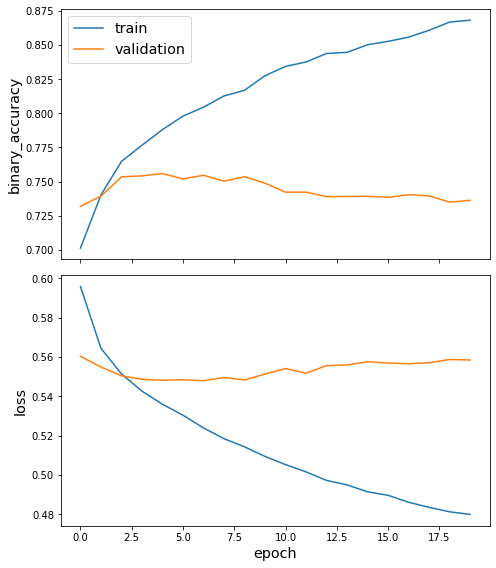

In [22]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [23]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

266/266 [==============================] - 10s 38ms/step - loss: 0.5583 - binary_accuracy: 0.7299 1s - loss: 0.5264 - binary_accuracy: 0.771 - ETA: 1s - loss: 0.5280 - binar - ETA: 0s - loss: 0.5542 - binary_accuracy: 0.

Train Set Metrics of the trained model:
	loss: 0.4645
	binary_accuracy: 0.8843

Validation Set Metrics of the trained model:
	loss: 0.5583
	binary_accuracy: 0.7356

Test Set Metrics of the trained model:
	loss: 0.5583
	binary_accuracy: 0.7299


In [24]:
num_tests = 1  # the number of times to generate predictions

In [25]:
all_test_predictions = [
    model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
]

266/266 [==============================] - 12s 45ms/step


## Diagnosing model miscalibration

We are going to use method from scikit-learn.calibration module to calibrate the binary classifier.

In [26]:
calibration_data = [
    calibration_curve(
        y_prob=test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True
    )
    for test_predictions in all_test_predictions
]

Let' calculate the expected calibration error on the test set before calibration.

In [27]:
for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_pre_calibration = expected_calibration_error(
        prediction_probabilities=all_test_predictions[0],
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,
    )
    print("ECE: (before calibration) {:.4f}".format(ece_pre_calibration))

ECE: (before calibration) 0.3758


Now let's plot the reliability diagram. This is a visual aid for the diagnosis of a poorly calibrated binary classifier.

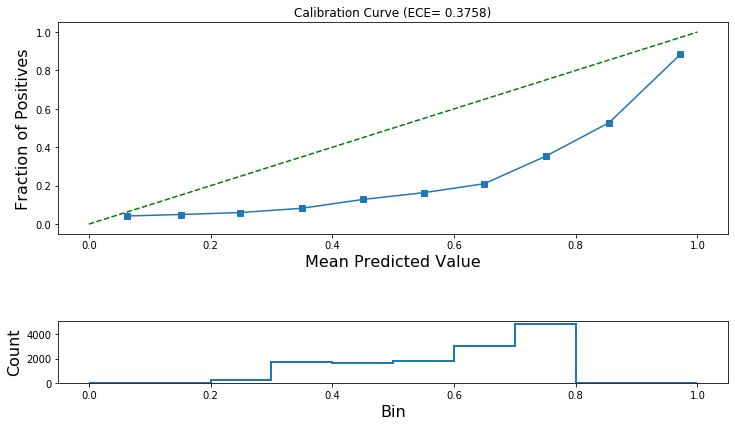

In [28]:
plot_reliability_diagram(
    calibration_data, np.array(all_test_predictions[0]), ece=[ece_pre_calibration]
)

## Model Calibration 

Next, we are going to use our validation set to calibrate the model.

We will consider two different approaches for calibrating a binary classifier, Platt scaling and Isotonic regression.

## Platt Scaling

$q_i = \sigma(\alpha z_i+\beta)$ where $z_i$ is the GraphSAGE output (before the last layer's activation function is applied), $q_i$ is the calibrated probability, and $\sigma()$ is the sigmoid function. 

$\alpha$ and $\beta$ are the model's trainable parameters.

For more information see:
- https://en.wikipedia.org/wiki/Platt_scaling

## Isotonic Regression

Isotonic Regression is a regression technique that fits a piece-wise, non-decreasing, linear function to data. For more information see:
- https://scikit-learn.org/stable/modules/generated/sklearn.isotonic.IsotonicRegression.html#sklearn.isotonic.IsotonicRegression
- https://en.wikipedia.org/wiki/Isotonic_regression

Select the calibration method.

In [29]:
use_platt = False  # True for Platt scaling or False for Isotonic Regression

For simplicity, we are going to calibrate using a single prediction per query point.

In [30]:
num_tests = 1

In [31]:
score_model = keras.Model(inputs=x_inp, outputs=logits)

In [32]:
if use_platt:
    all_val_score_predictions = [
        score_model.predict(val_flow, verbose=True) for _ in np.arange(num_tests)
    ]
    all_test_score_predictions = [
        score_model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
    ]
    all_test_probabilistic_predictions = [
        model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
    ]
else:
    all_val_score_predictions = [
        model.predict(val_flow, verbose=True) for _ in np.arange(num_tests)
    ]
    all_test_probabilistic_predictions = [
        model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
    ]

266/266 [==============================] - 11s 40ms/step


In [33]:
val_predictions = np.mean(np.array(all_val_score_predictions), axis=0)
val_predictions.shape

(15074, 1)

In [34]:
# These are the uncalibrated prediction probabilities.
if use_platt:
    test_predictions = np.mean(np.array(all_test_score_predictions), axis=0)
    test_predictions.shape
else:
    test_predictions = np.mean(np.array(all_test_probabilistic_predictions), axis=0)
    test_predictions.shape

In [35]:
if use_platt:
    # for binary classification this class performs Platt Scaling
    lr = TemperatureCalibration()
else:
    lr = IsotonicCalibration()

In [36]:
val_predictions.shape, edge_labels_val.shape

((15074, 1), (15074,))

In [37]:
lr.fit(val_predictions, edge_labels_val)

In [38]:
lr_test_predictions = lr.predict(test_predictions)

In [39]:
lr_test_predictions.shape

(13300, 1)

Let's check if these predictions are calibrated!

If calibration is successful then the ECE after calibration will be lower and the calibration curve will track the ideal diagonal line more closely.

In [40]:
calibration_data = [
    calibration_curve(
        y_prob=lr_test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True
    )
]

In [41]:
for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_post_calibration = expected_calibration_error(
        prediction_probabilities=lr_test_predictions,
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,
    )
    print("ECE (after calibration): {:.4f}".format(ece_post_calibration))

ECE (after calibration): 0.0174


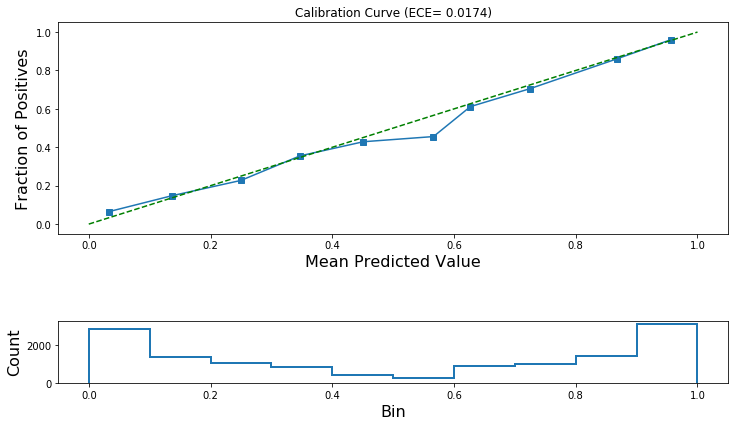

In [42]:
plot_reliability_diagram(
    calibration_data, lr_test_predictions, ece=[ece_post_calibration]
)

As a final test, check if the accuracy of the model changes after calibration.

In [43]:
y_pred = np.zeros(len(test_predictions))
if use_platt:
    # the true predictions are the probabilistic outputs
    test_predictions = np.mean(np.array(all_test_probabilistic_predictions), axis=0)
y_pred[test_predictions.reshape(-1) > 0.5] = 1
print(
    "Accuracy of model before calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)

Accuracy of model before calibration: 0.73


In [44]:
y_pred = np.zeros(len(lr_test_predictions))
y_pred[lr_test_predictions[:, 0] > 0.5] = 1
print(
    "Accuracy for model after calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)

Accuracy for model after calibration: 0.83


## Conclusion

This notebook demonstrated how to use Platt scaling and isotonic regression to calibrate a GraphSAGE model used for link prediction in a paper citation network. Importantly, it showed that using calibration can improve the classification model's accuracy.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/calibration/calibration-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/calibration/calibration-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>